Notebook to study LJ pT and bound state mass resolution

In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
import awkward as ak
from dask.distributed import Client
#plotting
import matplotlib.pyplot as plt
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from analysis.tools import ffschema, sidm_processor
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)

<module 'analysis.tools.sidm_processor' from '/home/cms-jovyan/SIDM/analysis/studies/../../analysis/tools/sidm_processor.py'>

Start by looking at default 2mu2e sample with 2mu2e selection (with and without LJ pT cut) and matched dark photons.

In [2]:
fileset = {
    "2Mu2E_100GeV_1p2GeV_9p6mm": [
        "root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-100_mA-1p2_ctau-9p6_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_161703/0000/ffNtuple_1.root",
    ],
    # can't open new files at the moment; waiting on intervention from coffea-casa folks
    #"2Mu2E_100GeV_1p2GeV_0p096mm": [
    #    "root://xcache//store/group/lpcmetx/SIDM/ffNtupleV4/2018/SIDM_XXTo2ATo2Mu2E_mXX-100_mA-1p2_ctau-0p096_TuneCP5_13TeV-madgraph-pythia8/RunIIAutumn18DRPremix-102X_upgrade2018_realistic_v15-v1/210326_155855/0000/ffNtuple_1.root",
    #],
}

In [3]:
runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    #executor=processor.FuturesExecutor(),
    schema=ffschema.FFSchema,
)

p = sidm_processor.SidmProcessor(
    [
        "2mu2e_matchedLj",
        "2mu2e_matchedLj_noLjPtCut",
    ],
    ["base_plus_gen"]
)

output = runner.run(fileset, treename="ffNtuplizer/ffNtuple", processor_instance=p)
hists = output["out"]["2Mu2E_100GeV_1p2GeV_9p6mm"]["hists"]

Output()

Output()

Take a look at ratio of LJ pT to dark photon pT

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fa686312f10>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

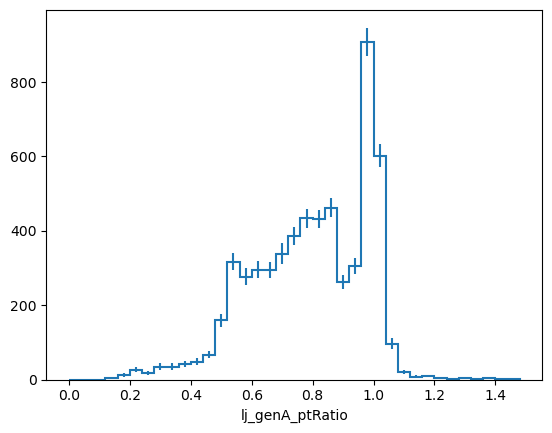

In [4]:
hists["lj_genA_ptRatio_lj_type"]["2mu2e_matchedLj_noLjPtCut", :1.5j, :].project("lj_genA_ptRatio").plot1d()

Weird... The peak at 1.0 looks good, and it's skewed to low values like I suspected it might be, but the dip around 0.9 is odd. Ah, I bet the distributions vary by type. Let's see:

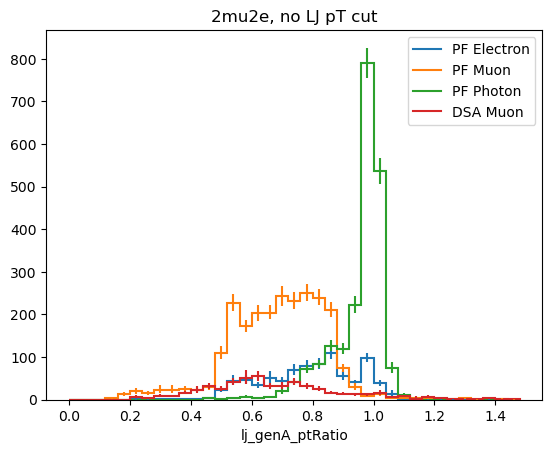

In [5]:
lj_type_names = {
    2: "PF Electron",
    3: "PF Muon",
    4: "PF Photon",
    8: "DSA Muon",
}
hists["lj_genA_ptRatio_lj_type"]["2mu2e_matchedLj_noLjPtCut", :1.5j, :].stack("lj_type").plot()
plt.title("2mu2e, no LJ pT cut")
plt.legend(lj_type_names.values())
plt.show()

Yup, that's pretty clear cut. PF photon LJs have pretty good resolution, though it's skewed towards smaller values, PF muon LJs are systematically low, DSA muon LJs are systematically low and have a wide distribution, and PF electron LJs show a blend of the PF photon and PF muon behavior. How about with a 30GeV LJ pT cut imposed?

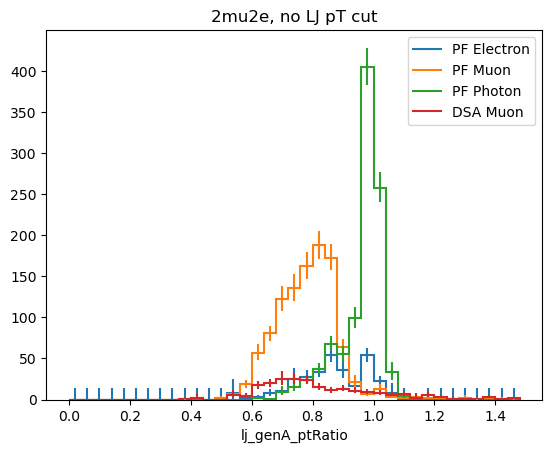

In [6]:
hists["lj_genA_ptRatio_lj_type"]["2mu2e_matchedLj", :1.5j, :].stack("lj_type").plot()
plt.title("2mu2e, no LJ pT cut")
plt.legend(lj_type_names.values())
plt.show()

No major difference other than cutting out the lowest pT LJs, I think. Remember from expore_genParticles notebook that dark photon pT peaks sharply at 50GeV in this sample.

Would be nice to see how this varies with bound state mass and dark photon decay length, but coffea-casa has an xcache issue at the moment, so come back to this point later.

Next I'll try to understand whether the issue is pT misreconstruction, a failure to include some dark photon daughters in the LJs, or something else. I'll pop over to the explore_genParticles notebook to look at the daughter e and mu a bit.

Ok, the basic gen-level observations from explore_genParticles are that all of the dark photon pT is indeed carried by two e or two mu that tend to be very close together (dR=~0.05 for 100GeV, 9p6mm), and one of the two daughter leptons usually carries ~70% of the dark photon momentum.

 Next, I'd like to understand the number and pT distributions of the reco e, mu, and gamma associated with each LJ. To do this, I'll first need to make sure ffschema is handling the LJ valuemaps correctly.